## Installs and Imports

# Final Project - Reinforcements Learning 
Hello dear students,<br> this is the template notebook. Please click on the "File" tab and then on "Save a copy into drive".

---
<br>

### Name and ID:
Student 1: Dror Meirovich 031846819
<br>
Student 2: N/A
<br><br>
# Goodluck!

In [1]:
!pip install highway-env
!pip install git+https://github.com/DLR-RM/stable-baselines3
!pip install tensorboardx gym pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg
!git clone https://github.com/eleurent/highway-env.git 2> /dev/null
!git clone https://github.com/drormeir/HighwayRL.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/DLR-RM/stable-baselines3 to /tmp/pip-req-build-tkx4q7e7
  Running command git clone -q https://github.com/DLR-RM/stable-baselines3 /tmp/pip-req-build-tkx4q7e7
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.11).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
fatal: destination path 'HighwayRL' alrea

In [6]:
import gym
import highway_env
import sys
sys.path.insert(0, '/content/highway-env/scripts/')
from tqdm.notebook import trange
from utils import record_videos, show_videos
import numpy as np
from gym import logger as gymlogger
from gym.wrappers import Monitor
from gym.utils import seeding
from gym import error, spaces, utils
gymlogger.set_level(40) # error only
import io
import base64
import os
import random
import matplotlib.pyplot as plt
import math
import glob
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pygame
import json
import ast
%load_ext tensorboard
%matplotlib inline

In [7]:
class ReplayBuffer:
    def __init__(self,
                 state_size, state_type,
                 action_size, action_type,
                 params=None,
                 seed: int = 0):
        if params is None:
            params = {'sample_every': 1, 'buffer_size': int(1e6), 'batch_size': 64}
        assert action_type == int or action_type == float
        self.state_size = state_size
        if action_type == int:  # DQN
            self.action_begin = 0
            self.action_end = action_size
            self.action_size = 1
        else:  # action_type == float --> DDPG
            self.action_begin = None
            self.action_end = None
            self.action_size = action_size
        self.state_type = state_type
        self.action_type = action_type
        self.buffer_size = params['buffer_size']
        self.batch_size = params['batch_size']
        self.current_len = 0
        self.sample_every = params['sample_every']
        self.last_sample_len = 0
        self.random = np.random.default_rng(seed=seed)

        def np_empty(buffer_size, shape, d_type):
            if isinstance(shape, int):
                shape = (shape,)
            buffer_shape = (buffer_size,) + shape
            return np.empty(buffer_shape, dtype=d_type)

        self.states = np_empty(self.buffer_size, self.state_size, d_type=self.state_type)
        self.actions = np_empty(self.buffer_size, self.action_size, d_type=self.action_type)
        self.rewards = np_empty(self.buffer_size, 1, d_type=np.float32)
        self.next_states = np_empty(self.buffer_size, self.state_size, d_type=self.state_type)
        self.dones = np_empty(self.buffer_size, 1, d_type=int)

        self.res_states = np_empty(self.batch_size, self.state_size, d_type=self.state_type)
        self.res_actions = np_empty(self.batch_size, self.action_size, d_type=self.action_type)
        self.res_rewards = np_empty(self.batch_size, 1, d_type=np.float32)
        self.res_next_states = np_empty(self.batch_size, self.state_size, d_type=self.state_type)
        self.res_dones = np_empty(self.batch_size, 1, d_type=int)

    def add_and_sample(self, state, action, reward, next_state, done):
        self.add(state, action, reward, next_state, done)
        if self.current_len < self.last_sample_len + self.sample_every:
            # No new mini batch
            return None
        self.last_sample_len = self.current_len
        return self.sample()

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        active_len = min(self.current_len, self.buffer_size)
        if active_len < self.batch_size:
            # Not enough samples are available in memory
            return None
        indexes = self.random.choice(range(active_len), size=self.batch_size, replace=False)
        self.res_states[:] = self.states[indexes, :]
        self.res_actions[:] = self.actions[indexes, :]
        self.res_rewards[:] = self.rewards[indexes, :]
        self.res_next_states[:] = self.next_states[indexes, :]
        self.res_dones[:] = self.dones[indexes, :]
        return self.res_states, self.res_actions, self.res_rewards, self.res_next_states, self.res_dones

    def add(self, state, action, reward, next_state, done):
        if self.action_type == int and self.action_size == 1:
            assert action >= self.action_begin
            assert action < self.action_end
        ind_pos = self.current_len % self.buffer_size
        self.states[ind_pos, :] = state
        self.actions[ind_pos][0] = action
        self.rewards[ind_pos][0] = reward
        self.next_states[ind_pos, :] = next_state
        self.dones[ind_pos][0] = done
        self.current_len += 1


In [8]:
import shutil

import numpy as np
import torch
import torch.nn.functional as F
from torch import autograd, optim, nn


class HighwayActorModelDQN(nn.Module):
    def __init__(self, state_size, action_size, model_params, seed: int = 0, pytorch_device=None):
        """Initialize parameters and build model.
        Params
        ======
            state_size (tuple): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            pytorch_device (str): pytorch cuda device name
        """
        super().__init__()
        self.model_params = model_params
        ch_conv1, ch_conv2 = model_params['ch_conv1'], model_params['ch_conv2']
        fc0_out, fc1_out, fc2_out = model_params['fc0_out'], model_params['fc1_out'], model_params['fc2_out']
        self.seed = seed
        self.torch_seed = torch.manual_seed(seed)
        self.state_size = state_size
        self.action_size = action_size
        self.conv = nn.Sequential(
            nn.Conv2d(self.state_size[0], ch_conv1, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(ch_conv1, ch_conv2, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        feature_dim = self.conv(autograd.Variable(torch.zeros(1, *self.state_size))).view(1, -1).size(1)
        self.base_stream = nn.Sequential(
            nn.Linear(feature_dim, fc0_out),
            nn.ReLU()
        )
        self.value_stream = nn.Sequential(
            nn.Linear(fc0_out, fc1_out),
            nn.ReLU(),
            nn.Linear(fc1_out, 1)
        )
        self.advantage_stream = nn.Sequential(
            nn.Linear(fc0_out, fc2_out),
            nn.ReLU(),
            nn.Linear(fc2_out, self.action_size)
        )
        self.apply(HighwayActorModelDQN.init_weights)

        self.pytorch_device = pytorch_device
        if isinstance(pytorch_device, str):
            pytorch_device = pytorch_device.lower()
            if any(pytorch_device.startswith(device_name) for device_name in ['gpu', 'cuda']):
                if torch.cuda.is_available():
                    self.to(torch.device('cuda:0'))

    def clone(self):
        ret = HighwayActorModelDQN(state_size=self.state_size, action_size=self.action_size,
                                   model_params=self.model_params,
                                   seed=self.seed, pytorch_device=self.pytorch_device)
        ret.soft_update_from_local(self, 1.0)
        return ret

    @property
    def my_device(self):
        return next(self.parameters()).device

    def act(self, state):
        self.eval()
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.my_device)
        with torch.no_grad():
            action_values = self(state).cpu().data.numpy()
        return int(np.argmax(action_values))

    def q_targets(self, rewards, gamma, dones, next_states):
        self.eval()
        rewards = torch.from_numpy(rewards).float().to(self.my_device)
        dones = torch.from_numpy(dones).int().to(self.my_device)
        next_states = torch.from_numpy(next_states).float().to(self.my_device)
        # Get max predicted Q values (for next states) from target model
        q_targets_next = self(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states
        q_targets = rewards + gamma * (1 - dones) * q_targets_next
        return q_targets

    def q_expected(self, states, actions):
        self.train()
        # Get expected Q values from local model
        states = torch.from_numpy(states).float().to(self.my_device)
        actions = torch.from_numpy(actions).long().to(self.my_device)
        q_expected = self(states).gather(1, actions)
        return q_expected

    def soft_update_from_local(self, local_q_network, local_tau_weight):
        for target_param, local_param in zip(self.parameters(), local_q_network.parameters()):
            target_param.data.copy_(local_tau_weight * local_param.data + (1.0 - local_tau_weight) * target_param.data)

    def forward(self, state):
        features = self.conv(state)
        features = features.view(features.size(0), -1)
        features = self.base_stream(features)
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)
        q_vals = values + (advantages - advantages.mean())
        return q_vals

    def save(self, filename):
        shutil.rmtree(filename, ignore_errors=True)  # avoid file not found error
        torch.save(self.state_dict(), filename)

    def load(self, filename):
        self.load_state_dict(torch.load(filename))

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)


class OptimizerDQN:
    def __init__(self, local_q_network, lr):
        self.optimizer = optim.Adam(local_q_network.parameters(), lr=lr)

    def step(self, q_expected, q_targets):
        if isinstance(q_targets, list):
            q_targets = torch.min(torch.stack(q_targets), dim=0)[0]  # [0] to get the values
        # Compute loss
        loss = F.mse_loss(q_expected, q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def save(self, filename):
        shutil.rmtree(filename, ignore_errors=True)  # avoid file not found error
        torch.save(self.optimizer.state_dict(), filename)

    def load(self, filename):
        self.optimizer.load_state_dict(torch.load(filename))



In [9]:

class HighwayAgentDQN:
    def __init__(self, state_size, action_size,
                 seed=0,
                 eps_greedy_min=0.01, eps_greedy_decay=0.981,
                 replay_buffer_size: int = int(1e4),
                 replay_batch_size: int = 40,
                 train_every_episode_steps=2,
                 gamma=0.987,
                 local_tau_weight=0.003,
                 num_targets: int = 1,
                 lr=5e-4,
                 ch_conv1=16,
                 ch_conv2=64,
                 fc0_out=180,
                 fc1_out=180,
                 fc2_out=200,
                 reward_power=1.5,
                 pytorch_device=None,
                 verbose_level=1):

        self.eps_greedy = 1.0
        self.eps_greedy_min = eps_greedy_min
        self.eps_greedy_decay = eps_greedy_decay
        self.action_size = action_size
        self.state_size = state_size
        self.reward_power = reward_power
        self.random = np.random.default_rng(seed=seed)
        model_params = {'ch_conv1': ch_conv1, 'ch_conv2': ch_conv2,
                        'fc0_out': fc0_out, 'fc1_out': fc1_out, 'fc2_out': fc2_out}
        self.local_q_network = HighwayActorModelDQN(state_size=self.state_size, action_size=self.action_size,
                                                    model_params=model_params,
                                                    seed=seed, pytorch_device=pytorch_device)
        self.target_q_network = [
            HighwayActorModelDQN(state_size=self.state_size, action_size=self.action_size, model_params=model_params,
                                 seed=seed + i_target, pytorch_device=pytorch_device)
            for i_target in range(num_targets)]

        replay_buffer_params = {'sample_every': train_every_episode_steps,
                                'buffer_size': replay_buffer_size, 'batch_size': replay_batch_size}
        self.replay_buffer = ReplayBuffer(state_size=self.state_size, state_type=np.uint8,
                                          action_size=self.action_size, action_type=int,
                                          params=replay_buffer_params,
                                          seed=seed)
        self.optimizer = OptimizerDQN(self.local_q_network, lr=lr)
        self.ind_next_step_in_episode = 0
        self.gamma = gamma
        self.local_tau_weight = local_tau_weight
        self.verbose_level = verbose_level
        if self.verbose_level > 0:
            print('Initializing HighwayAgentDQN with:')
            print(f'Epsilon Greedy: min={self.eps_greedy_min} decay={self.eps_greedy_decay}')
            print(f'Gamma = {self.gamma}')
            print(f'tau = {self.local_tau_weight}')
            print(f'Replay Buffer: {replay_buffer_params}')
            print(f'Learning rate = {lr:4.2e}')
            print(f'Model params = {model_params}')
        self.params_dict = {'replay_buffer': replay_buffer_params, 'Q_network': model_params, 'gamma': gamma,
                            'tau': self.local_tau_weight, 'learning_rate': lr, 'epsilon_min': self.eps_greedy_min,
                            'epsilon_decay': self.eps_greedy_decay, 'reward_power': self.reward_power, 'seed': seed}

    def act(self, state, training):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            training (bool): true = epsilon-greedy action selection
        """
        if training:
            if self.random.random() < self.eps_greedy:
                # explore the environment using random move
                return int(self.random.choice(self.action_size))
        # exploit the agent knowledge
        return self.local_q_network.act(state)

    def step(self, state, action, reward, next_state, done, info):
        # ind_curr_step_in_episode = self.ind_next_step_in_episode
        if done:
            # episode can end because reaching maximum steps, hence set done == True iff crash
            done = info['crashed']
            # preparing for next episode...
            self.ind_next_step_in_episode = 0
            self.eps_greedy = max(self.eps_greedy * self.eps_greedy_decay, self.eps_greedy_min)
        else:
            self.ind_next_step_in_episode += 1
        # minimal velocity has reward of 0.7 and maximal velocity has reward close to 1.0
        # hence, encourage agent achieve higher velocity
        reward = math.pow(reward, self.reward_power)
        state = state.astype(np.uint8)
        next_state = next_state.astype(np.uint8)
        experiences = self.replay_buffer.add_and_sample(state, action, reward, next_state, done)
        if experiences is None:
            return
        states, actions, rewards, next_states, dones = experiences

        q_targets = [q_target.q_targets(rewards, self.gamma, dones, next_states) for q_target in self.target_q_network]

        q_expected = self.local_q_network.q_expected(states, actions)

        self.optimizer.step(q_expected, q_targets)

        for q_target in self.target_q_network:
            q_target.soft_update_from_local(self.local_q_network, local_tau_weight=self.local_tau_weight)

    def save_param_dict(self, filename):
        with open(filename, 'w') as f:
            json.dump(self.params_dict, f)

    def load_param_dict(self, filename):
        with open(filename, 'r') as f:
            self.params_dict = json.load(f)


## Display utils
The cell below contains the video display configuration. No need to make changes here.

In [10]:
display = Display(visible=0, size=(1400, 900))
display.start()

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    
def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

## EX1 - Highway-Env - Grayscale Image - Easy


Initializing HighwayAgentDQN with:
Epsilon Greedy: min=0.01 decay=0.981
Gamma = 0.987
tau = 0.003
Replay Buffer: {'sample_every': 2, 'buffer_size': 10000, 'batch_size': 40}
Learning rate = 5.00e-04
Model params = {'ch_conv1': 16, 'ch_conv2': 64, 'fc0_out': 180, 'fc1_out': 180, 'fc2_out': 200}
{'ch_conv1': 16, 'ch_conv2': 64, 'fc0_out': 180, 'fc1_out': 180, 'fc2_out': 200}


RuntimeError: ignored

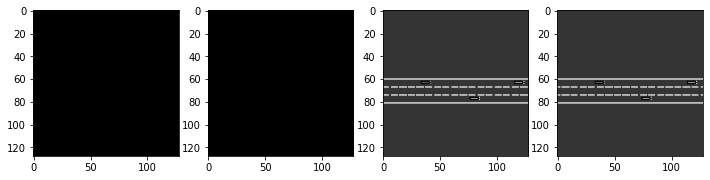

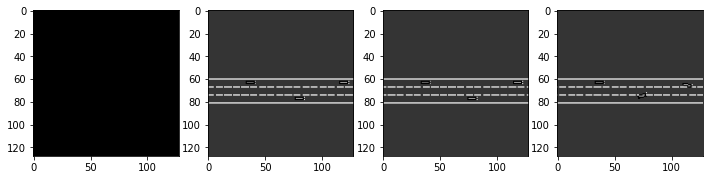

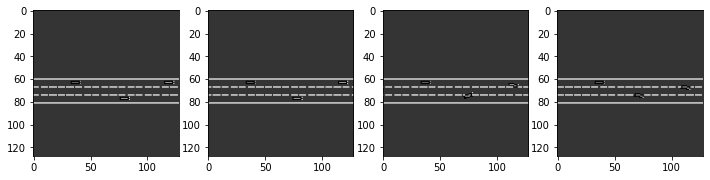

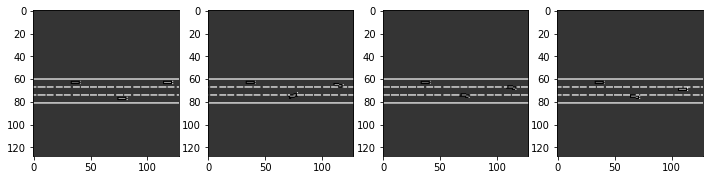

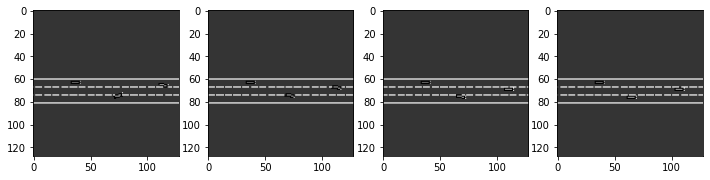

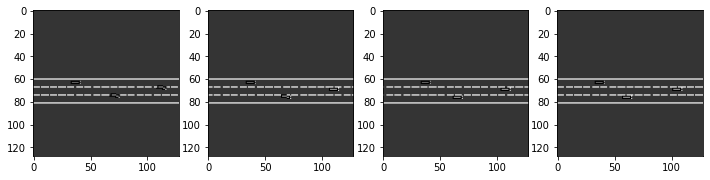

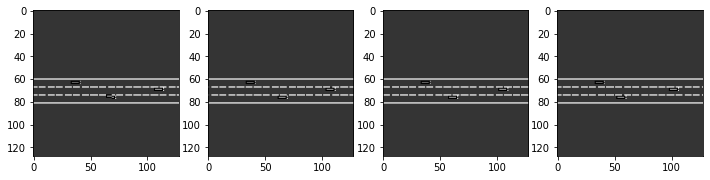

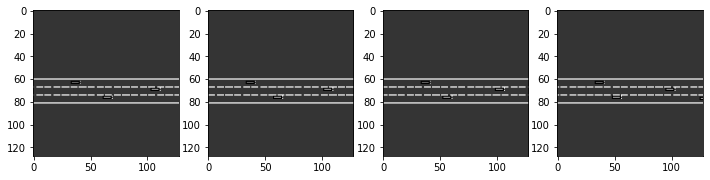

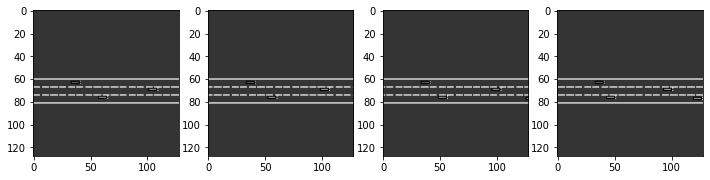

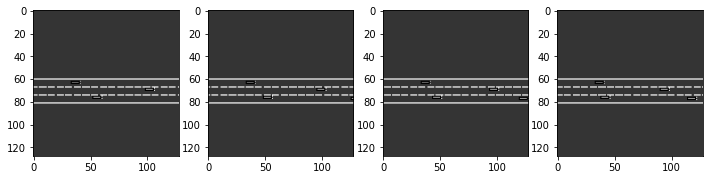

In [13]:
#=============== DO NOT DELETE ===============
file = open('/content/HighwayRL/highway-config/config_ex1.txt', 'r')
contents = file.read()
config1 = ast.literal_eval(contents)
file.close()
# ============================================

env = gym.make("highway-fast-v0")
env.configure(config1)
obs = env.reset()
for j in range(10):
    obs, _, _, _ = env.step(0)

    _, axes = plt.subplots(ncols=4, figsize=(12, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(obs[i, ...].T, cmap=plt.get_cmap('gray'))
    

env = wrap_env(env)
state = env.reset()
done = False
iter = 0

agent = HighwayAgentDQN(state_size=env.observation_space.shape, action_size=1)
print(agent.local_q_network.)
agent.local_q_network.load('/content/HighwayRL/results/EX1/best_training.pth')

while not done:
    iter +=1
    action = agent.act(state, training=False)  # select an action
    observation, reward, done, _ = env.step(action)
    screen = env.render(mode='rgb_array')
    plt.imshow(screen)
    print(f'iteration: {iter}, action: {action}, reward: {reward}, done: {done}')
    state = observation

In [ ]:
env.close()
show_video()

# EX2 - Highway-Env - Grayscale Image - Medium

In [ ]:
#=============== DO NOT DELETE ===============
file = open('/content/HighwayRL/highway-config/config_ex2.txt', 'r')
contents = file.read()
config2 = ast.literal_eval(contents)
file.close()
# ============================================

env = gym.make("highway-fast-v0")
env.configure(config2)

obs = env.reset()
for j in range(10):
    sam_act = env.action_space.sample()
    obs, _, _, _ = env.step(sam_act)

    _, axes = plt.subplots(ncols=4, figsize=(12, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(obs[i, ...].T, cmap=plt.get_cmap('gray'))
    
env = wrap_env(env)
env.reset()
done = False
iter = 0
while (iter < 40) or not done:
  if done:
    break
  iter +=1
  action = env.action_space.sample()
  observation, reward, done, _ = env.step(action)
  screen = env.render(mode='rgb_array')
  plt.imshow(screen)
  print(f'iteration: {iter}, action: {action}, reward: {reward}, done: {done}')

### Play video

In [ ]:
env.close()
show_video()

# Ex3 - Super Highway Agent

In [ ]:
#=============== DO NOT DELETE ===============
file = open('/content/HighwayRL/highway-config/config_ex3.txt', 'r')
contents = file.read()
config3 = ast.literal_eval(contents)
file.close()
# ============================================

### Ex3 - Highway-Env

In [ ]:
env = gym.make("highway-fast-v0")
env.configure(config3) 
env = wrap_env(env)
env.reset()
done = False
iter = 0
while (iter < 10) or not done:
  if done:
    break
  iter +=1
  action = env.action_space.sample()
  observation, reward, done, _ = env.step(action)
  screen = env.render(mode='rgb_array')
  plt.imshow(screen)
  print(f'iteration: {iter}, action: {action}, reward: {reward}, done: {done}')

### Play video

In [ ]:
env.close()
show_video()

### Ex3 - Merge-Env

In [ ]:
env = gym.make("merge-v0")
env.configure(config3) 
env = wrap_env(env)
env.reset()
done = False
iter = 0

while (iter < 10) or not done:
  if done:
    break
  iter +=1
  action = env.action_space.sample()
  observation, reward, done, _ = env.step(action)
  screen = env.render(mode='rgb_array')
  plt.imshow(screen)
  print(f'iteration: {iter}, action: {action}, reward: {reward}, done: {done}')

### Play video


In [ ]:
env.close()
show_video()

### Ex3 - Roundabout-Env

In [ ]:
env = gym.make("roundabout-v0")
env.configure(config3) 
env = wrap_env(env)
env.reset()
done = False
iter = 0
while (iter < 10) or not done:
  if done:
    break
  iter +=1
  action = env.action_space.sample()
  observation, reward, done, _ = env.step(action)
  screen = env.render(mode='rgb_array')
  plt.imshow(screen)
  print(f'iteration: {iter}, action: {action}, reward: {reward}, done: {done}')

### Play video

In [ ]:
env.close()
show_video()